In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from tabulate import tabulate

In [9]:
TPB = 256  #Число потоков на блок для GPU
ITER = 70  #Количество итераций для усреднения времени выполнения
EPS = 1e-8  #Константа для избежания деления на ноль

#Для суммирования на GPU
@cuda.jit
def gpu_vec_sum(vec, res):
    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x
    idx = tx + bx * TPB

    if idx < vec.shape[0]:
        cuda.atomic.add(res, 0, vec[idx])

#Для суммирования на CPU
def vector_sum_cpu(vector):
    answer = 0
    for elem in vector:
        answer += elem
    return answer

def calculation():
    rows = []
    vec_sizes = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]

    for vec_size in vec_sizes:
        cpu_time_sum, gpu_time_sum = 0., 0.

        for _ in range(ITER):
            vec = np.ones(vec_size, dtype=np.int32)
            res = np.zeros(1, dtype=np.int32)

            #Сложение на GPU
            d_vec = cuda.to_device(vec)
            d_res = cuda.to_device(res)
            start = time.time()
            gpu_vec_sum[(vec_size + TPB - 1) // TPB, TPB](d_vec, d_res)
            gpu_time_sum += time.time() - start
            res = d_res.copy_to_host()

            #Сложение на CPU
            start = time.time()
            vector_sum_cpu(vec)
            cpu_time_sum += time.time() - start

        #Средние значения времени
        avg_cpu_time = cpu_time_sum / ITER
        avg_gpu_time = gpu_time_sum / ITER
        speedup = avg_cpu_time / (avg_gpu_time if avg_gpu_time > EPS else EPS)

        #Добавление строки с результатами
        row = [
            vec_size,
            avg_cpu_time,
            avg_gpu_time,
            speedup
        ]
        rows.append(row)

    print(tabulate(rows, headers=["Размер вектора", "Время на CPU (с)", "Время на GPU (с)", "Ускорение"]))
    return rows

def plot_results(results):
    vec_sizes = [row[0] for row in results]
    cpu_times = [row[1] for row in results]
    gpu_times = [row[2] for row in results]
    speedups = [row[3] for row in results]

    #График времени выполнения на CPU
    plt.figure(figsize=(10, 6))
    plt.plot(vec_sizes, cpu_times, label="Время на CPU", color="blue", marker="o")
    plt.xlabel("Размер вектора")
    plt.ylabel("Время (с)")
    plt.title("Время выполнения на CPU")
    plt.grid()
    plt.legend()

    #График времени выполнения на GPU
    plt.figure(figsize=(10, 6))
    plt.plot(vec_sizes, gpu_times, label="Время на GPU (Numba)", color="green", marker="o")
    plt.xlabel("Размер вектора")
    plt.ylabel("Время (с)")
    plt.title("Время выполнения на GPU")
    plt.grid()
    plt.legend()

    #График ускорения
    plt.figure(figsize=(10, 6))
    plt.plot(vec_sizes, speedups, label="Ускорение GPU относительно CPU", color="red", marker="o")
    plt.xlabel("Размер вектора")
    plt.ylabel("Ускорение")
    plt.title("Ускорение вычислений на GPU")
    plt.grid()
    plt.legend()

    plt.show()

  Размер вектора    Время на CPU (с)    Время на GPU (с)    Ускорение
----------------  ------------------  ------------------  -----------
            1000         0.000177779         8.8736e-05       2.00345
            5000         0.00117935          0.000117901     10.0029
           10000         0.00280957          0.000126447     22.2194
           50000         0.0284633           0.000160803    177.007
          100000         0.0484693           0.000404576    119.803
          500000         0.081294            0.000195922    414.93
         1000000         0.168709            0.00013739    1227.95


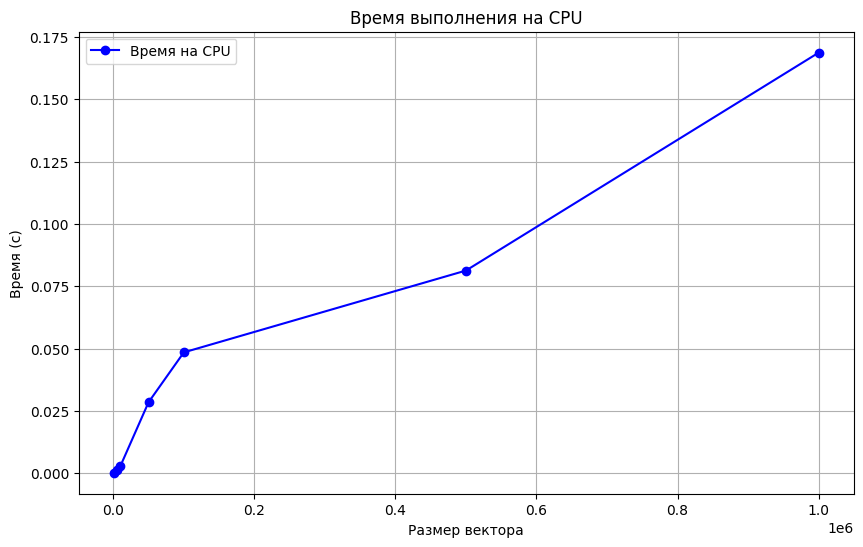

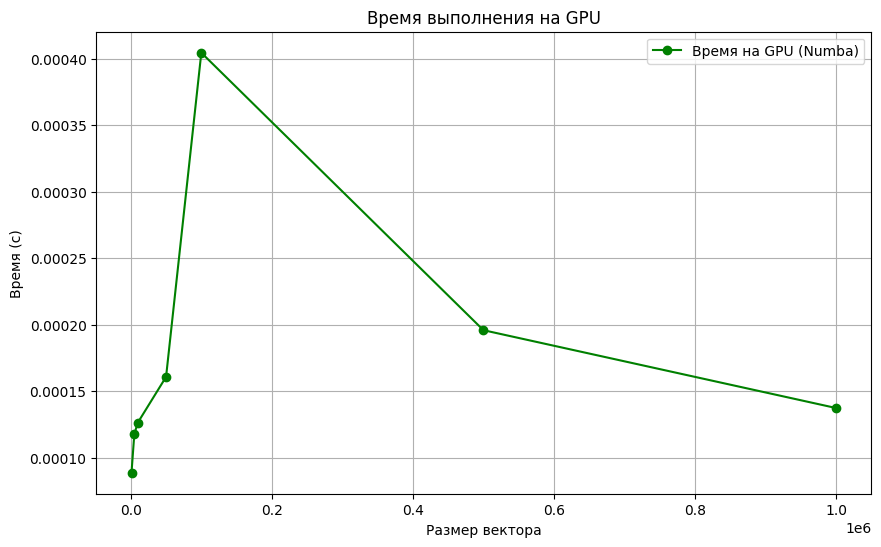

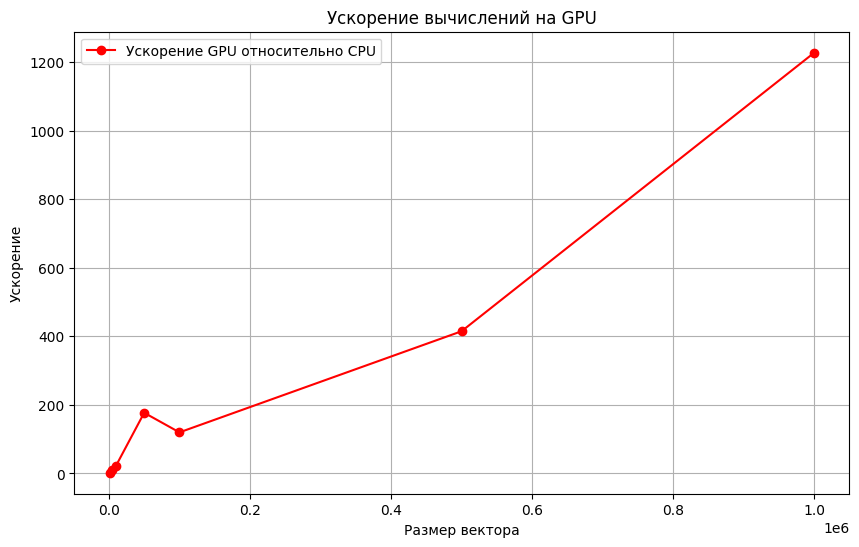

In [11]:
output_data = calculation()
plot_results(output_data)